<a href="https://colab.research.google.com/github/tgieruc/Noise2Noise_PyTorch/blob/main/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demo of Noise2Noise_PyTorch
This is a short demo for the Noise2Noise PyTorch implementation

In [1]:
!pip install -q -U --no-cache-dir gdown --pre

> This is for google colab only, if you run it locally you don't need to clone the repository

In [4]:
!git clone https://github.com/tgieruc/Noise2Noise_PyTorch
%cd Noise2Noise_PyTorch

Cloning into 'Noise2Noise_PyTorch'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 35 (delta 11), reused 19 (delta 5), pack-reused 0
Unpacking objects: 100% (35/35), done.
/content/Noise2Noise_PyTorch


Let's load the necessary libraries for the visualization of the results

In [5]:
import torch
import numpy as np

from matplotlib import pyplot as plt
from model import Model

Here we download the training and validation data, as well as the pretrained weights

In [6]:
!gdown 1bL4nZBwNs68WAuix3cq-LJZ7QrNIYWH6 # training data
!gdown 12nFadfp-uyiE8xtc3wFl9sNBZ_8EpT6m # validation data
!gdown 1JWUiX3jMr593zftQsp7YhHZSjN7xT3vG # pretrained weights

Downloading...
From: https://drive.google.com/uc?id=1bL4nZBwNs68WAuix3cq-LJZ7QrNIYWH6
To: /content/Noise2Noise_PyTorch/train_data.pkl
100% 307M/307M [00:03<00:00, 78.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=12nFadfp-uyiE8xtc3wFl9sNBZ_8EpT6m
To: /content/Noise2Noise_PyTorch/val_data.pkl
100% 6.14M/6.14M [00:00<00:00, 57.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1JWUiX3jMr593zftQsp7YhHZSjN7xT3vG
To: /content/Noise2Noise_PyTorch/model_pytorch.pth
100% 3.97M/3.97M [00:00<00:00, 210MB/s]


Helper functions for displaying the results

In [7]:
def display_rgb(img):
    plt.imshow(img.permute(1,2,0))
    plt.show()

def psnr_eval(model, noised, ground_truth, must_randomize=True):
    def psnr(denoised, ground_truth):
        mse = torch.mean((denoised.cpu() - ground_truth.cpu()) ** 2)
        return -10 * torch.log10(mse + 10 ** -8)
    clean_imgs = ground_truth.clone()
    noised = noised.float()
    ground_truth = ground_truth.float()

    denoised = model.predict(noised) / 255

    psnr_result = psnr(denoised, (ground_truth / 255)).item()
    print(f'PSNR result: {psnr_result}dB')

    nb_images = 3

    f, axarr = plt.subplots(nb_images, 3)

    if must_randomize:
        nb_index = np.random.choice(len(noised), nb_images)
    else:
        nb_index = np.arange(nb_images)
    axarr[0, 0].set_title("Noisy Images")
    axarr[0, 1].set_title("Denoised")
    axarr[0, 2].set_title("Ground Truth")

    for i, index in enumerate(nb_index):
        axarr[i, 0].imshow(noised[index].permute(1,2,0).int())
        axarr[i,0].get_yaxis().set_visible(False)
        axarr[i,0].get_xaxis().set_visible(False)
        axarr[i, 1].imshow(denoised[index].cpu().detach().permute(1,2,0))
        axarr[i, 1].get_yaxis().set_visible(False)
        axarr[i, 1].get_xaxis().set_visible(False)
        axarr[i, 2].imshow(clean_imgs[index].permute(1,2,0))
        axarr[i, 2].get_yaxis().set_visible(False)
        axarr[i, 2].get_xaxis().set_visible(False)
    plt.show()

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'The model will be loaded on the {"GPU" if device == "cuda" else "cpu"}.')

noisy_imgs_1, noisy_imgs_2 = torch.load('train_data.pkl')
noisy_imgs, clean_imgs = torch.load('val_data.pkl')

The model will be loaded on the GPU.


# Evaluation on the pre-trained model

In [9]:
model = Model()
model.load_pretrained_model("model_pytorch.pth")

PSNR result: 23.014965057373047dB


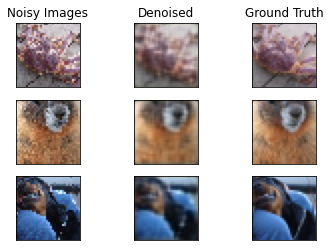

In [10]:
psnr_eval(model, noisy_imgs, clean_imgs, must_randomize=False)

# Training from scratch

In [11]:
model = Model()

In [12]:
model.train(noisy_imgs_1, noisy_imgs_2, num_epochs=5, batch_size=8, num_workers=1)

Epoch [4/5]: 100%|██████████| 6250/6250 [01:48<00:00, 57.46it/s, loss=0.0159]


PSNR result: 23.158580780029297dB


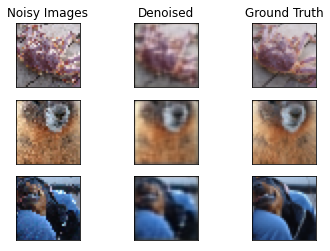

In [13]:
psnr_eval(model, noisy_imgs, clean_imgs, must_randomize=False)

In [ ]:
model.save("model.pth")